# Iterative diagonalization

In this tutorial we will perform the iterative diagonalization of different 1D models.

In orde to do so, we will use three new modules:

- getLocalSpace.jl: generates the operators for a site of spin, spinless or spinful fermions;
- getiIdentity.jl: Generates the identity operator for the Hilber space of one leg or for the product space of the spaces for two les;
- updateLeft.jl: Contract the operator residing in the Hilbert space of the left part of the MPS (with respect to a given site) with the local operators at a given site;


In [1]:
using LinearAlgebra, PyPlot

In [2]:
include("../Tensor_modules/time.jl");
include("../Tensor_modules/contract.jl");
include("../Tensor_modules/getLocalSpace.jl");
include("../Tensor_modules/getIdentity.jl");
include("../Tensor_modules/updateLeft.jl");

## Tight-binding Hamiltonian of spinless fermions

Let's consider the Hamiltonian of a 1D tight-binding chain of length N of non-interacting fermions:

\begin{equation}
\hat{H} = -t\sum_{l=1}^{N-1}(\hat{c}_{l+1}^\dagger\hat{c}_{l}+\hat{c}_{l}^\dagger\hat{c}_{l+1})
\end{equation}

Since this is not an interacting mode, the ground-state energy can be obtained in a simple manner, by directly diagonalization of the Hamiltonian in the first-quantized (i.e. single-particle) basis $\{|1>,|2>,\dots,|N>\}$:

In [3]:
### DIRECT DIAGONALIZATION OF TB HAMILTONIAN

t = 1; # hopping amplitude
N = 50; # number of sites in the chain

Hsp = zeros(N,N); # tight-binding hamiltonian
# Generate the upper diagonal
for i in 1:(N-1)
    Hsp[i,i+1] = -t;
end
# Generate the hermitian hamiltonian
Hsp = Hsp + Hsp';

# Diagnoalize the Hamiltonian
E,V = eigen(Hsp);

# Ground-state energy per site
E_tot_per_site = sum(E[E.<0])/N;
println("GS energy per site = $E_tot_per_site")

GS energy per site = -0.6294548456051772


Notice that the Hamiltonian is "Hermitianized" before being diagonalized (i.e Hsp = Hsp + Hsp'). 

In principle, the Hamiltonian should be Hermitian. However, in practice, the numerical representation of the Hamiltonian is susceptible to noise, so that it becomes slightly non-Hermitian leading to complex-valued eigenvalues (which should be always real for an Hamiltonian of a physical system) and eigenvectors (which should be real-valued).

To avoid this numerical noise, one can Hermitianize the Hamiltonian when it is diagonalized.

### Iterative diagonalization

We now move to the second-quantized (many-body) basis and, for different chain lengths, we will perform iterative diagonalization of the Hamiltonian starting from single-particle basis.

In [4]:
# Initialize parameters

N = 100; # Maximum chain length
Nkeep = 300; # Maximal number of states to keep
tol = Nkeep*100*eps(); # Numerical tolerance for degeneracy

# Get local Hilbert space for spinless fermions on a given site
# F  -> annihilation operator
# Z  -> Jordan-Wigner transformation for fermion sign
# Id -> Identity operator
F,Z,Id = getLocalSpace("Fermion");

In order to reduce computational time, we can truncate the Hilbert space. By doing so we are reducing the number of possible eigenvalues and eigenvectors.

Therefore, at each iteration, we need to keep all the states whose energies are close to the truncation threshold. The "closeness" is determined by the tolerance parameter tol, and we regard the states separated within this tolerance as being degenerate. The degeneracy often comes from physical symmetries, such as spin and particle-hole symmetry. If we keep only the part of the degenerate states, then the Hilbert space will not respect the symmetry anymore. This artificial symmetry breaking would lead to qualitatively wrong result.

Now, we initialize the Hamiltonian and the ket state on the first site: the legs of H0 and the third leg of A0 are associated with the same Hilbert space. The left leg (i.e., first leg) of A0 is a dummy leg which has trivial dimension 1. To generate such dummy leg, we use a number as the first input to getidentity. Note that it does not need to be 1; it can be any number, as long as it is 1-by-1 object.

In [5]:
## Site 1 initialization
H0 = Id*0; # Hamiltonian for the 1st site
A0 = getIdentity([1],2,Id,2); # Ket for the first site:
                              # 1st leg is vacuum, i.e. dummy leg

Now perform iterative diagonalization:

In [6]:
# Initialize vector containing lowest energies at each iteration
E0 = zeros(N,1);
Hprev = [];
Fprev = [];

for it in 1:N
    if it == 1
        ## Diagonalize first site
        Hnow = H0;
        E,V = eigen((Hnow+Hnow')./2);
        AK = contract(A0,3,[3],V,2,[1]);
        E0[it] = minimum(E);
        Hprev = zeros(size(E,1),size(E,1));
        for i in length(size(E,1))
            Hprev[i,i] = E[i];
        end
    else
        ## Add a new site
        Anow = getIdentity(Hprev,2,Id,2);
        Hnow = updateLeft(Hprev,2,Anow,[],[],Anow);
        
        ## Update the Hamiltonian up to the last sites of the enlarged Hilbert space
        # Creation operator at the new site
        Fn = permutedims(conj(F),[3 2 1]);
        # F'*Z : contract fermionic sign operator
        Fn = contract(Fn,3,[3],Z,2,[1]);
        # Hoppin from the last site to the new site
        Hhop = updateLeft(Fprev,3,Anow,Fn,3,Anow);
        Hhop = -t.*Hhop; # multiply hopping amplitude
        # add the hopping term from the new site to the last site
        Hhop = Hhop+Hhop';
        
        Hnow = Hnow+Hhop;
        E,V = eigen((Hnow+Hnow')./2);
        E0[it] = minimum(E);
        
        ## Truncation threshold for energy
        # We keep all degenerate states up to a tolerance
        Etr = E[min(length(E),Nkeep)];
        oks = 1;
        while E[oks] < (Etr+tol) && oks < length(E)
            oks += 1
        end
        if E[oks] >= (Etr+tol)
            oks -=1
        end
        AK = contract(Anow,3,[3],V[:,1:oks],2,[1]);
        Hprev = zeros(oks,oks);
        for i in 1:oks
            Hprev[i,i] = E[i];
        end
    end
    
    # Particle annihilation operator at the current site
    # It is used to generate the hopping term at the next iteration
    Fprev = updateLeft([],[],AK,F,3,AK);
    
    ## Printing infos
    print_time()
    println(" | #$it/$N : NK = $(size(AK,3))/$(size(Hnow,2))")
    
end

7/11/2020 16:8:45 (GMT) | #1/100 : NK = 2/2
7/11/2020 16:8:46 (GMT) | #2/100 : NK = 4/4
7/11/2020 16:8:46 (GMT) | #3/100 : NK = 8/8
7/11/2020 16:8:46 (GMT) | #4/100 : NK = 16/16
7/11/2020 16:8:46 (GMT) | #5/100 : NK = 32/32
7/11/2020 16:8:47 (GMT) | #6/100 : NK = 64/64
7/11/2020 16:8:47 (GMT) | #7/100 : NK = 128/128
7/11/2020 16:8:47 (GMT) | #8/100 : NK = 256/256
7/11/2020 16:8:50 (GMT) | #9/100 : NK = 302/512
7/11/2020 16:8:52 (GMT) | #10/100 : NK = 300/604
7/11/2020 16:8:54 (GMT) | #11/100 : NK = 300/600
7/11/2020 16:8:57 (GMT) | #12/100 : NK = 300/600
7/11/2020 16:8:59 (GMT) | #13/100 : NK = 300/600
7/11/2020 16:9:1 (GMT) | #14/100 : NK = 300/600
7/11/2020 16:9:4 (GMT) | #15/100 : NK = 300/600
7/11/2020 16:9:6 (GMT) | #16/100 : NK = 300/600
7/11/2020 16:9:9 (GMT) | #17/100 : NK = 300/600
7/11/2020 16:9:11 (GMT) | #18/100 : NK = 301/600
7/11/2020 16:9:14 (GMT) | #19/100 : NK = 300/602
7/11/2020 16:9:16 (GMT) | #20/100 : NK = 301/600
7/11/2020 16:9:19 (GMT) | #21/100 : NK = 300/602
7/

Each line gives the time, the # of sites up to a maximum of 100 in this case and how many eigenvalues are kept (NK).

Then, in order to have the ground-state energy per site at different chain lengths, we compute:

In [7]:
EG_iter = zeros(N,1);
for i in 1:N
    EG_iter[i] = E0[i]/i;
end

In order to check if our result is consistent, we perform exact diagonalization of the TB hamiltonian in the single-particle basis:

In [8]:
EG_single = zeros(N,1);
for it in 1:N
    Hsp = zeros(it,it);
    for i in 1:(it-1)
        Hsp[i,i+1] = -t;
    end
    Hsp = Hsp + Hsp';
    E,V = eigen((Hsp+Hsp')./2);
    EG_single[it] = sum(E[E.<0])/it;
end

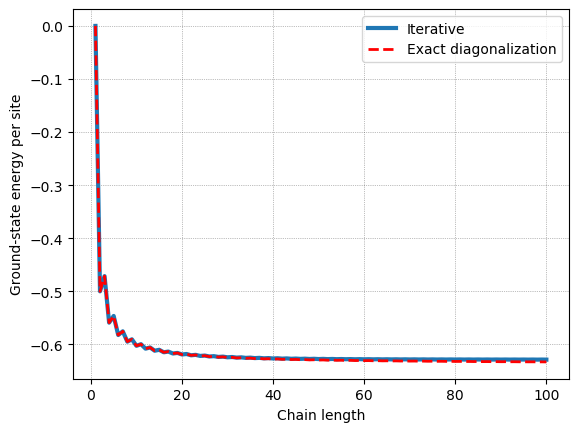

In [9]:
x = (1:N)
ylabel("Ground-state energy per site");
xlabel("Chain length")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,EG_iter,linewidth=3.0,label="Iterative");
plot(x,EG_single,"--",linewidth=2.0,label="Exact diagonalization",color="red");
legend(loc="upper rigth");

We can also plot the error with respect to the exact numerical result:

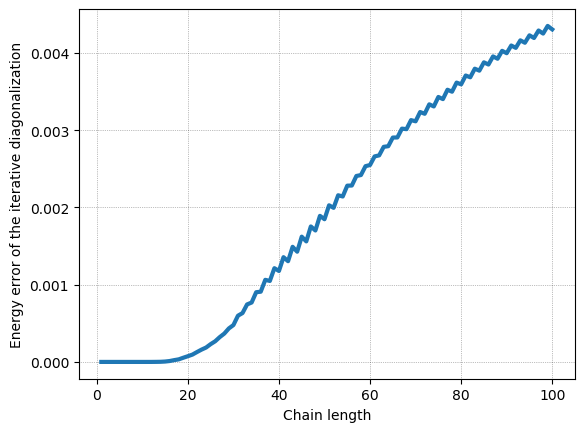

In [10]:
EG_error = zeros(N,1);
for i in 1:N
   EG_error[i] = abs(EG_iter[i]-EG_single[i]); 
end

x = (1:N);
ylabel("Energy error of the iterative diagonalization");
xlabel("Chain length")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,EG_error,linewidth=3.0,label="Iterative");

We observe that the error increases consistently, as the chain length grows. Note that, for short chains for which we can keep all the states, the iterative diagonalization result is identical to the single-particle basis result (up to double precision error).

### Note

We see that, for such example, the result of the iterative diagonalization is not that bad. 
However, there are some limitations:

- It is hard to go to the thermodynamic limit (i.e., the limit of infinite system size);
- The truncation error (i.e., error induced by truncating the Hilbert space) accumulates as one proceeds with the iterations;
- It is hard to achieve higher accuracy. Larger Nkeep leads to better accuracy, but it also requires larger computational cost;
- Iterative diagonalization works badly for most of the systems of interacting particles. For those, we will employ the numerical renormalization group (NRG) and the density- matrix renormalization group (DMRG).

## Heisenberg spin chains

The Hamiltonian for the Heisenberg spin chain of length N is given by:

\begin{equation}
\hat{H}=J\sum_{l=1}^{N-1}\hat{\bf{S}}_{l}\cdot\hat{\bf{S}}_{l+1}
\end{equation}

In the next we will consider:

- spin-1/2 chain
- spin-1 chain

Without loss of generality, set J=1.

### Spin-1/2 Heisenberg chain

In [11]:
# Initialize parameters

N = 100; # Maximum chain length
Nkeep = 300; # Maximal number of states to keep
tol = Nkeep*100*eps(); # Numerical tolerance for degeneracy
J = 1;

# Get local Hilbert space for spinless fermions on a given site
# S  -> Spin operators:
#       S(:,1,:) : spin raising operator S_+ multiplied with 1/sqrt(2)
#       S(:,2,:) : spin lowering operator S_- multiplied with 1/sqrt(2)
#       S(:,3,:) : spin-z operator S_z
# Id -> Identity operator
S,Id = getLocalSpace("Spin",0.5);

## Site 1 initialization
H0 = Id*0; # Hamiltonian for the 1st site
A0 = getIdentity([1],2,Id,2); # Ket for the first site:
                              # 1st leg is vacuum, i.e. dummy leg

## Initialize vector containing lowest energies at each iteration
E0 = zeros(N,1);

Hprev = [];
Sprev = [];
## Iterative diagonalization
for it in 1:N
    if it == 1
        ## Diagonalize first site
        Hnow = H0;
        E,V = eigen((Hnow+Hnow')./2);
        AK = contract(A0,3,[3],V,2,[1]);
        E0[it] = minimum(E);
        Hprev = zeros(size(E,1),size(E,1));
        for i in length(size(E,1))
            Hprev[i,i] = E[i];
        end
    else
        ## Add a new site
        Anow = getIdentity(Hprev,2,Id,2);
        Hnow = updateLeft(Hprev,2,Anow,[],[],Anow);
        # Update the Hamiltonian up to the last sites of the enlarged Hilbert space
        
        ## spin-spin interaction
        # Hermitian conjugate of the spin operator at the current site
        Sn = permutedims(conj(S),[3 2 1])
        Hss = updateLeft(Sprev,3,Anow,Sn,3,Anow);
        Hss = J*Hss;
        
        Hnow = Hnow+Hss;
        E,V = eigen((Hnow+Hnow')./2);
        E0[it] = minimum(E);
        
        ## Truncation threshold for energy
        # We keep all degenerate states up to a tolerance
        Etr = E[min(length(E),Nkeep)];
        oks = 1;
        while E[oks] < (Etr+tol) && oks < length(E)
            oks += 1
        end
        if E[oks] >= (Etr+tol)
            oks -=1
        end
        AK = contract(Anow,3,[3],V[:,1:oks],2,[1]);
        Hprev = zeros(oks,oks);
        for i in 1:oks
            Hprev[i,i] = E[i];
        end
    end
    
    # Spin operator at the current site
    # used for the coupling term at the next iteration
    Sprev = updateLeft([],[],AK,S,3,AK);
    
    ## Printing infos
    print_time()
    println(" | #$it/$N : NK = $(size(AK,3))/$(size(Hnow,2))")
    
end

7/11/2020 16:13:14 (GMT) | #1/100 : NK = 2/2
7/11/2020 16:13:14 (GMT) | #2/100 : NK = 4/4
7/11/2020 16:13:14 (GMT) | #3/100 : NK = 8/8
7/11/2020 16:13:14 (GMT) | #4/100 : NK = 16/16
7/11/2020 16:13:14 (GMT) | #5/100 : NK = 32/32
7/11/2020 16:13:14 (GMT) | #6/100 : NK = 64/64
7/11/2020 16:13:15 (GMT) | #7/100 : NK = 128/128
7/11/2020 16:13:15 (GMT) | #8/100 : NK = 256/256
7/11/2020 16:13:18 (GMT) | #9/100 : NK = 300/512
7/11/2020 16:13:21 (GMT) | #10/100 : NK = 302/600
7/11/2020 16:13:25 (GMT) | #11/100 : NK = 302/604
7/11/2020 16:13:29 (GMT) | #12/100 : NK = 303/604
7/11/2020 16:13:32 (GMT) | #13/100 : NK = 300/606
7/11/2020 16:13:36 (GMT) | #14/100 : NK = 302/600
7/11/2020 16:13:39 (GMT) | #15/100 : NK = 302/604
7/11/2020 16:13:42 (GMT) | #16/100 : NK = 303/604
7/11/2020 16:13:45 (GMT) | #17/100 : NK = 300/606
7/11/2020 16:13:48 (GMT) | #18/100 : NK = 300/600
7/11/2020 16:13:51 (GMT) | #19/100 : NK = 304/600
7/11/2020 16:13:54 (GMT) | #20/100 : NK = 301/608
7/11/2020 16:13:57 (GMT) | 

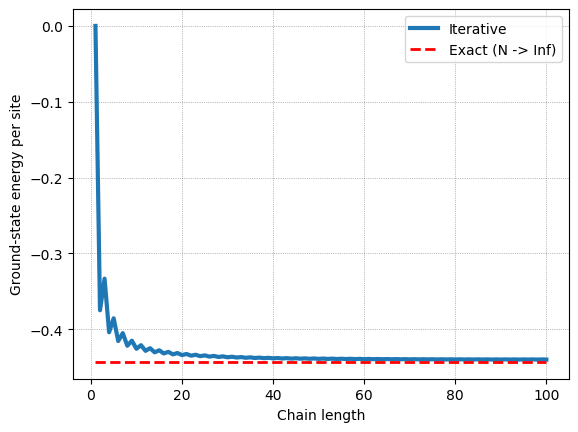

In [12]:
EG_iter  = zeros(N,1);
EG_exact = zeros(N,1);
for i in 1:N
    EG_iter[i]  = E0[i]/i;
    EG_exact[i] = 0.25 - log(2);
end

x = (1:N)
ylabel("Ground-state energy per site");
xlabel("Chain length")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,EG_iter,linewidth=3.0,label="Iterative");
plot(x,EG_exact,"--",linewidth=2.0,label="Exact (N -> Inf)",color="red");
legend(loc="upper rigth");

### Spin-1 Heisenberg chain

In [13]:
# Initialize parameters

N = 100; # Maximum chain length
Nkeep = 300; # Maximal number of states to keep
tol = Nkeep*100*eps(); # Numerical tolerance for degeneracy
J = 1;

# Get local Hilbert space for spinless fermions on a given site
# S  -> Spin operators:
#       S(:,1,:) : spin raising operator S_+ multiplied with 1/sqrt(2)
#       S(:,2,:) : spin lowering operator S_- multiplied with 1/sqrt(2)
#       S(:,3,:) : spin-z operator S_z
# Id -> Identity operator
S,Id = getLocalSpace("Spin",1.0);

## Site 1 initialization
H0 = Id*0; # Hamiltonian for the 1st site
A0 = getIdentity([1],2,Id,2); # Ket for the first site:
                              # 1st leg is vacuum, i.e. dummy leg

## Initialize vector containing lowest energies at each iteration
E0 = zeros(N,1);

Hprev = [];
Sprev = [];
## Iterative diagonalization
for it in 1:N
    if it == 1
        ## Diagonalize first site
        Hnow = H0;
        E,V = eigen((Hnow+Hnow')./2);
        AK = contract(A0,3,[3],V,2,[1]);
        E0[it] = minimum(E);
        Hprev = zeros(size(E,1),size(E,1));
        for i in length(size(E,1))
            Hprev[i,i] = E[i];
        end
    else
        ## Add a new site
        Anow = getIdentity(Hprev,2,Id,2);
        Hnow = updateLeft(Hprev,2,Anow,[],[],Anow);
        # Update the Hamiltonian up to the last sites of the enlarged Hilbert space
        
        ## spin-spin interaction
        # Hermitian conjugate of the spin operator at the current site
        Sn = permutedims(conj(S),[3 2 1])
        Hss = updateLeft(Sprev,3,Anow,Sn,3,Anow);
        Hss = J*Hss;
        
        Hnow = Hnow+Hss;
        E,V = eigen((Hnow+Hnow')./2);
        E0[it] = minimum(E);
        
        ## Truncation threshold for energy
        # We keep all degenerate states up to a tolerance
        Etr = E[min(length(E),Nkeep)];
        oks = 1;
        while E[oks] < (Etr+tol) && oks < length(E)
            oks += 1
        end
        if E[oks] >= (Etr+tol)
            oks -=1
        end
        AK = contract(Anow,3,[3],V[:,1:oks],2,[1]);
        Hprev = zeros(oks,oks);
        for i in 1:oks
            Hprev[i,i] = E[i];
        end
    end
    
    # Spin operator at the current site
    # used for the coupling term at the next iteration
    Sprev = updateLeft([],[],AK,S,3,AK);
    
    ## Printing infos
    print_time()
    println(" | #$it/$N : NK = $(size(AK,3))/$(size(Hnow,2))")
    
end

7/11/2020 16:18:41 (GMT) | #1/100 : NK = 3/3
7/11/2020 16:18:41 (GMT) | #2/100 : NK = 9/9
7/11/2020 16:18:41 (GMT) | #3/100 : NK = 27/27
7/11/2020 16:18:41 (GMT) | #4/100 : NK = 81/81
7/11/2020 16:18:42 (GMT) | #5/100 : NK = 243/243
7/11/2020 16:18:46 (GMT) | #6/100 : NK = 300/729
7/11/2020 16:18:52 (GMT) | #7/100 : NK = 300/900
7/11/2020 16:18:58 (GMT) | #8/100 : NK = 301/900
7/11/2020 16:19:5 (GMT) | #9/100 : NK = 304/903
7/11/2020 16:19:11 (GMT) | #10/100 : NK = 300/912
7/11/2020 16:19:17 (GMT) | #11/100 : NK = 304/900
7/11/2020 16:19:24 (GMT) | #12/100 : NK = 308/912
7/11/2020 16:19:30 (GMT) | #13/100 : NK = 301/924
7/11/2020 16:19:36 (GMT) | #14/100 : NK = 301/903
7/11/2020 16:19:43 (GMT) | #15/100 : NK = 302/903
7/11/2020 16:19:49 (GMT) | #16/100 : NK = 301/906
7/11/2020 16:19:55 (GMT) | #17/100 : NK = 304/903
7/11/2020 16:20:1 (GMT) | #18/100 : NK = 301/912
7/11/2020 16:20:8 (GMT) | #19/100 : NK = 304/903
7/11/2020 16:20:14 (GMT) | #20/100 : NK = 301/912
7/11/2020 16:20:20 (GMT)

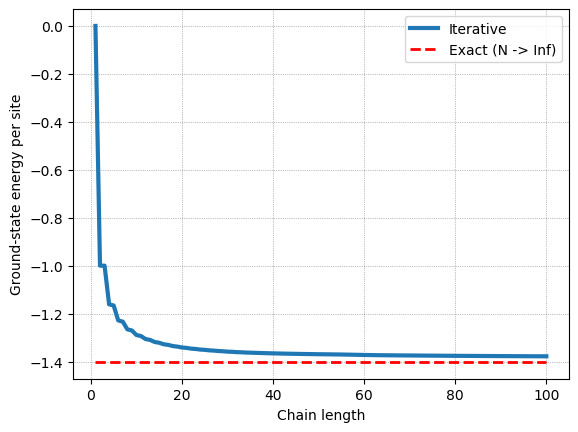

In [14]:
EG_iter  = zeros(N,1);
EG_exact = zeros(N,1);
for i in 1:N
    EG_iter[i]  = E0[i]/i;
    EG_exact[i] = -1.401484039;
end

x = (1:N)
ylabel("Ground-state energy per site");
xlabel("Chain length")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,EG_iter,linewidth=3.0,label="Iterative");
plot(x,EG_exact,"--",linewidth=2.0,label="Exact (N -> Inf)",color="red");
legend(loc="upper rigth");

## Spin-1/2 fermions on a chain with an interacting site at one end

Let's consider a 1D tight-binding chain of length N of spin-1/2 fermions.
On the first site we put a local Coulomb interaction of strength U: the spin-up and -down particles sitting together at the first chain site experience extra energy U. The rest of the chain is non-interacting.

Its Hamiltonian is given by:

\begin{equation}
\hat{H} = -t\sum_{s=\uparrow,\downarrow}\sum_{l=1}^{N-1}(\hat{c}_{l+1,s}^\dagger\hat{c}_{l,s}+\hat{c}_{l,s}^\dagger\hat{c}_{l+1,s}+U\hat{n}_{1\uparrow}\hat{n}_{1\downarrow}-\frac{U}{2}(\hat{n}_{1\uparrow}+\hat{n}_{1\downarrow})
\end{equation}

Without loss of generality we set t=1. However for U we will consider the limiting cases $U=0$ and $U\rightarrow\infty$.

### U=0 solution

For the case of $U=0$, the ground-state energy per site is twice the value in the demonstration of the spinless case. Spin-up and -down particles are totally independent, so we can consider the system as two copies of spinless fermions on a chain. Thus the contribution to the ground-state energy by each spin add up. Let's compare this with the iterative diagonalization result.

In [15]:
## Initialize variables
U = 0; # interaction strength
t = 1; # hopping amplitude
N = 50; # number of sites in the chain

## Single-particle solution
EG_single = zeros(N,1);
for it in 1:N
    Hsp = zeros(it,it);
    for i in 1:(it-1)
        Hsp[i,i+1] = -t;
    end
    Hsp = Hsp + Hsp';
    E,V = eigen((Hsp+Hsp')./2);
    EG_single[it] = 2*sum(E[E.<0])/it; # note the spin degeneracy, 2.
end

## Iterative diagonalization
Nkeep = 300; # Maximal number of states to keep
tol = Nkeep*100*eps(); # Numerical tolerance for degeneracy

# Get local Hilbert space for spinless fermions on a given site
# F  -> annihilation operator
# Z  -> Jordan-Wigner transformation for fermion sign
# S  -> Spin operator
# Id -> Identity operator
F,Z,S,Id = getLocalSpace("FermionS");

# Build the number operators
# Spin up
N1 = contract(reshape(conj(F[:,1,:]),(4,1,4)),3,[1 2],reshape(F[:,1,:],(4,1,4)),3,[1 2]);
# Spin down
N2 = contract(reshape(conj(F[:,2,:]),(4,1,4)),3,[1 2],reshape(F[:,2,:],(4,1,4)),3,[1 2]);

## Site 1 initialization
H0 = U*N1*N2 - 0.5*U*(N1+N2); # Hamiltonian for the 1st site
A0 = getIdentity([1],2,Id,2); # Ket for the first site:
                              # 1st leg is vacuum, i.e. dummy leg

# Initialize vector containing lowest energies at each iteration
E0 = zeros(N,1);
Hprev = [];
Fprev = [];

for it in 1:N
    if it == 1
        ## Diagonalize first site
        Hnow = H0;
        E,V = eigen((Hnow+Hnow')./2);
        AK = contract(A0,3,[3],V,2,[1]);
        E0[it] = minimum(E);
        Hprev = zeros(size(E,1),size(E,1));
        for i in length(size(E,1))
            Hprev[i,i] = E[i];
        end
    else
        ## Add a new site
        Anow = getIdentity(Hprev,2,Id,2);
        Hnow = updateLeft(Hprev,2,Anow,[],[],Anow);
        
        ## Update the Hamiltonian up to the last sites of the enlarged Hilbert space
        # Creation operator at the new site
        Fn = permutedims(conj(F),[3 2 1]);
        # F'*Z : contract fermionic sign operator
        Fn = contract(Fn,3,[3],Z,2,[1]);
        # Hoppin from the last site to the new site
        Hhop = updateLeft(Fprev,3,Anow,Fn,3,Anow);
        Hhop = -t.*Hhop; # multiply hopping amplitude
        # add the hopping term from the new site to the last site
        Hhop = Hhop+Hhop';
        
        Hnow = Hnow+Hhop;
        E,V = eigen((Hnow+Hnow')./2);
        E0[it] = minimum(E);
        
        ## Truncation threshold for energy
        # We keep all degenerate states up to a tolerance
        Etr = E[min(length(E),Nkeep)];
        oks = 1;
        while E[oks] < (Etr+tol) && oks < length(E)
            oks += 1
        end
        if E[oks] >= (Etr+tol)
            oks -=1
        end
        AK = contract(Anow,3,[3],V[:,1:oks],2,[1]);
        Hprev = zeros(oks,oks);
        for i in 1:oks
            Hprev[i,i] = E[i];
        end
    end
    
    # Particle annihilation operator at the current site
    # It is used to generate the hopping term at the next iteration
    Fprev = updateLeft([],[],AK,F,3,AK);
    
    ## Printing infos
    print_time()
    println(" | #$it/$N : NK = $(size(AK,3))/$(size(Hnow,2))")
    
end

7/11/2020 16:28:53 (GMT) | #1/50 : NK = 4/4
7/11/2020 16:28:53 (GMT) | #2/50 : NK = 16/16
7/11/2020 16:28:53 (GMT) | #3/50 : NK = 64/64
7/11/2020 16:28:53 (GMT) | #4/50 : NK = 256/256
7/11/2020 16:29:0 (GMT) | #5/50 : NK = 360/1024
7/11/2020 16:29:14 (GMT) | #6/50 : NK = 300/1440
7/11/2020 16:29:25 (GMT) | #7/50 : NK = 300/1200
7/11/2020 16:29:35 (GMT) | #8/50 : NK = 302/1200
7/11/2020 16:29:44 (GMT) | #9/50 : NK = 300/1208
7/11/2020 16:29:53 (GMT) | #10/50 : NK = 305/1200
7/11/2020 16:30:3 (GMT) | #11/50 : NK = 304/1220
7/11/2020 16:30:13 (GMT) | #12/50 : NK = 306/1216
7/11/2020 16:30:23 (GMT) | #13/50 : NK = 304/1224
7/11/2020 16:30:32 (GMT) | #14/50 : NK = 300/1216
7/11/2020 16:30:41 (GMT) | #15/50 : NK = 304/1200
7/11/2020 16:30:51 (GMT) | #16/50 : NK = 300/1216
7/11/2020 16:31:2 (GMT) | #17/50 : NK = 304/1200
7/11/2020 16:31:12 (GMT) | #18/50 : NK = 301/1216
7/11/2020 16:31:22 (GMT) | #19/50 : NK = 300/1204
7/11/2020 16:31:31 (GMT) | #20/50 : NK = 300/1200
7/11/2020 16:31:40 (GMT)

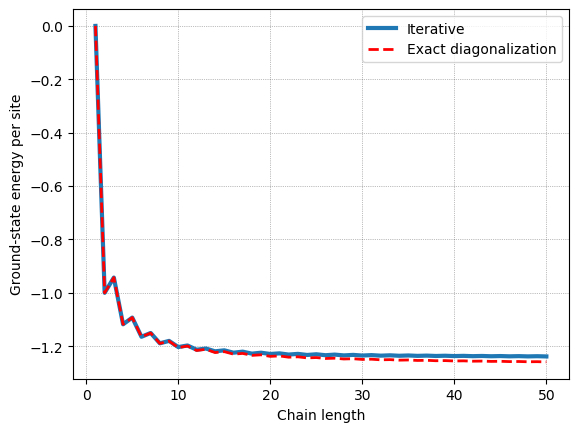

In [16]:
EG_iter = zeros(N,1);
for i in 1:N
    EG_iter[i] = E0[i]/i;
end

x = (1:N)
ylabel("Ground-state energy per site");
xlabel("Chain length")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,EG_iter,linewidth=3.0,label="Iterative");
plot(x,EG_single,"--",linewidth=2.0,label="Exact diagonalization",color="red");
legend(loc="upper rigth");

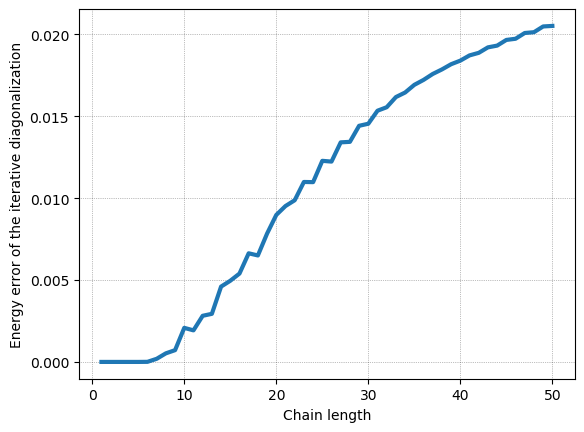

In [17]:
EG_error = zeros(N,1);
for i in 1:N
   EG_error[i] = abs(EG_iter[i]-EG_single[i]); 
end

x = (1:N);
ylabel("Energy error of the iterative diagonalization");
xlabel("Chain length")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,EG_error,linewidth=3.0,label="Iterative");

Though the semi-analytic solution for the $U=0$ case is identical to that for the spinless case up to factor 2, the iterative diagonalization result here has larger error than in the spinless case. It is because we have used the same bond dimention Nkeep to solve "larger" system. Here the local Hilbert space dimension is 4, which is larger than 2 in the spinless case. And the entanglement entropy is twice as large, since the ground-state here is the direct product of two copies of the ground-state in the spinless case.

### U=Inf solution

In this case, the repulsion term for the site 1 in the Hamiltonian is the dominant one. So the ground state should be such that we have a low energy configuration with respect to the term. The lowest-energy states of the site 1 are singly occupied states: $|\uparrow>_1$ and $|\downarrow>_1$. The doubly occupied state $|\uparrow\downarrow>_1$  and the empty $|0>_1$ state have higher energy due to $U/2$. The hopping between the site 1 and the site 2 is irrelvant in
the ground state, since the hopping induces charge fluctuation at the site 1 which has huge energy penalty. Then the rest of the system, ranging from the site 2 to N, behaves as a non-interacting chain of length $N-1$. So the ground-state energy for the $U\rightarrow\infty$ case is given by the sum of the energy at the site 1 ($=-U/2$) and the ground-state energy of the chain of length $N-1$.

In [18]:
## Initialize variables
U = 1e6; # interaction strength
t = 1; # hopping amplitude
N = 50; # number of sites in the chain

## Single-particle solution
EG_single = zeros(N,1);
for it in 1:N
    Hsp = zeros(it,it);
    for i in 1:(it-1)
        Hsp[i,i+1] = -t;
    end
    Hsp = Hsp + Hsp';
    E,V = eigen((Hsp+Hsp')./2);
    EG_single[it] = (2*sum(E[E.<0])-0.5*U)/it; # note the spin degeneracy, 2.
end
    

## Iterative diagonalization
Nkeep = 300; # Maximal number of states to keep
tol = Nkeep*100*eps(); # Numerical tolerance for degeneracy

# Get local Hilbert space for spinless fermions on a given site
# F  -> annihilation operator
# Z  -> Jordan-Wigner transformation for fermion sign
# S  -> Spin operator
# Id -> Identity operator
F,Z,S,Id = getLocalSpace("FermionS");

# Build the number operators
# Spin up
N1 = contract(reshape(conj(F[:,1,:]),(4,1,4)),3,[1 2],reshape(F[:,1,:],(4,1,4)),3,[1 2]);
# Spin down
N2 = contract(reshape(conj(F[:,2,:]),(4,1,4)),3,[1 2],reshape(F[:,2,:],(4,1,4)),3,[1 2]);

## Site 1 initialization
H0 = U*N1*N2 - 0.5*U*(N1+N2); # Hamiltonian for the 1st site
A0 = getIdentity([1],2,Id,2); # Ket for the first site:
                              # 1st leg is vacuum, i.e. dummy leg

# Initialize vector containing lowest energies at each iteration
E0 = zeros(N,1);
Hprev = [];
Fprev = [];

for it in 1:N
    if it == 1
        ## Diagonalize first site
        Hnow = H0;
        E,V = eigen((Hnow+Hnow')./2);
        AK = contract(A0,3,[3],V,2,[1]);
        E0[it] = minimum(E);
        Hprev = zeros(size(E,1),size(E,1));
        for i in length(size(E,1))
            Hprev[i,i] = E[i];
        end
    else
        ## Add a new site
        Anow = getIdentity(Hprev,2,Id,2);
        Hnow = updateLeft(Hprev,2,Anow,[],[],Anow);
        
        ## Update the Hamiltonian up to the last sites of the enlarged Hilbert space
        # Creation operator at the new site
        Fn = permutedims(conj(F),[3 2 1]);
        # F'*Z : contract fermionic sign operator
        Fn = contract(Fn,3,[3],Z,2,[1]);
        # Hoppin from the last site to the new site
        Hhop = updateLeft(Fprev,3,Anow,Fn,3,Anow);
        Hhop = -t.*Hhop; # multiply hopping amplitude
        # add the hopping term from the new site to the last site
        Hhop = Hhop+Hhop';
        
        Hnow = Hnow+Hhop;
        E,V = eigen((Hnow+Hnow')./2);
        E0[it] = minimum(E);
        
        ## Truncation threshold for energy
        # We keep all degenerate states up to a tolerance
        Etr = E[min(length(E),Nkeep)];
        oks = 1;
        while E[oks] < (Etr+tol) && oks < length(E)
            oks += 1
        end
        if E[oks] >= (Etr+tol)
            oks -=1
        end
        AK = contract(Anow,3,[3],V[:,1:oks],2,[1]);
        Hprev = zeros(oks,oks);
        for i in 1:oks
            Hprev[i,i] = E[i];
        end
    end
    
    # Particle annihilation operator at the current site
    # It is used to generate the hopping term at the next iteration
    Fprev = updateLeft([],[],AK,F,3,AK);
    
    ## Printing infos
    print_time()
    println(" | #$it/$N : NK = $(size(AK,3))/$(size(Hnow,2))")
    
end

7/11/2020 16:37:1 (GMT) | #1/50 : NK = 4/4
7/11/2020 16:37:1 (GMT) | #2/50 : NK = 16/16
7/11/2020 16:37:1 (GMT) | #3/50 : NK = 64/64
7/11/2020 16:37:1 (GMT) | #4/50 : NK = 256/256
7/11/2020 16:37:14 (GMT) | #5/50 : NK = 301/1024
7/11/2020 16:37:31 (GMT) | #6/50 : NK = 299/1204
7/11/2020 16:37:42 (GMT) | #7/50 : NK = 299/1196
7/11/2020 16:37:53 (GMT) | #8/50 : NK = 299/1196
7/11/2020 16:38:3 (GMT) | #9/50 : NK = 299/1196
7/11/2020 16:38:12 (GMT) | #10/50 : NK = 299/1196
7/11/2020 16:38:21 (GMT) | #11/50 : NK = 299/1196
7/11/2020 16:38:31 (GMT) | #12/50 : NK = 299/1196
7/11/2020 16:38:41 (GMT) | #13/50 : NK = 299/1196
7/11/2020 16:38:51 (GMT) | #14/50 : NK = 299/1196
7/11/2020 16:39:0 (GMT) | #15/50 : NK = 299/1196
7/11/2020 16:39:11 (GMT) | #16/50 : NK = 299/1196
7/11/2020 16:39:19 (GMT) | #17/50 : NK = 299/1196
7/11/2020 16:39:29 (GMT) | #18/50 : NK = 299/1196
7/11/2020 16:39:37 (GMT) | #19/50 : NK = 299/1196
7/11/2020 16:39:45 (GMT) | #20/50 : NK = 299/1196
7/11/2020 16:39:54 (GMT) | 

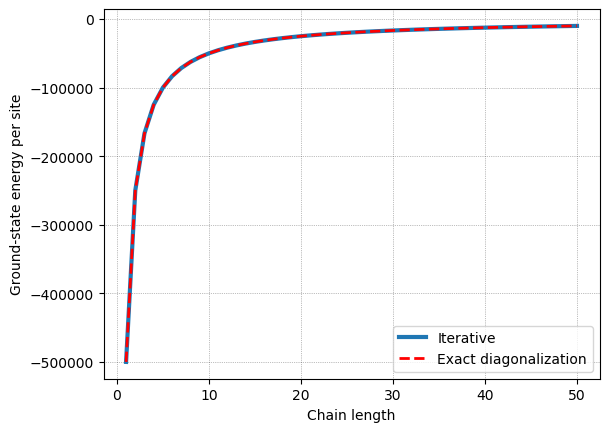

In [19]:
EG_iter = zeros(N,1);
for i in 1:N
    EG_iter[i] = E0[i]/i;
end

x = (1:N)
ylabel("Ground-state energy per site");
xlabel("Chain length")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,EG_iter,linewidth=3.0,label="Iterative");
plot(x,EG_single,"--",linewidth=2.0,label="Exact diagonalization",color="red");
legend(loc="upper rigth");

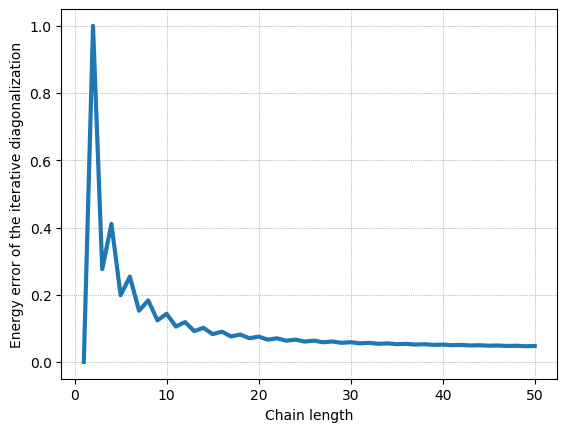

In [20]:
EG_error = zeros(N,1);
for i in 1:N
   EG_error[i] = abs(EG_iter[i]-EG_single[i]); 
end

x = (1:N);
ylabel("Energy error of the iterative diagonalization");
xlabel("Chain length")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,EG_error,linewidth=3.0,label="Iterative");